# Pothole Detection
## Tugas Besar Pengolahan Citra Digital


## Pipeline Overview:
1. **Resizing** (640×480)
2. **Grayscale Conversion** (RGB → Gray)
3. **Adaptive Threshold** (Block size 101, C=10)
4. **Canny Edge Detection** (sigma=3, low=0, high=150)
5. **Post-processing** (Dilasi + Multi-level Filtering)

In [1]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set matplotlib to display images properly
rcParams['figure.figsize'] = (15, 10)
%matplotlib inline

print("✅ OpenCV version:", cv2.__version__)
print("✅ NumPy version:", np.__version__)

✅ OpenCV version: 4.11.0
✅ NumPy version: 1.24.3


---
## Helper Function: Display Images Side-by-Side
Biar gampang compare before-after

In [2]:
def display_images(images, titles, cmap='gray', figsize=(15, 5)):
    """
    Display multiple images side-by-side
    
    Parameters:
    - images: list of images
    - titles: list of titles
    - cmap: colormap (default: 'gray')
    - figsize: figure size
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    if n == 1:
        axes = [axes]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 3:  # Color image (BGR)
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:  # Grayscale
            axes[i].imshow(img, cmap=cmap)
        
        axes[i].set_title(title, fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ Helper function loaded")

✅ Helper function loaded


---
## Step 0: Load Test Image
Pakai gambar test dulu (nanti ganti dengan foto lubang asli)

✅ Image loaded: (482, 765, 3)
   - Height: 482 pixels
   - Width: 765 pixels
   - Channels: 3 (RGB)


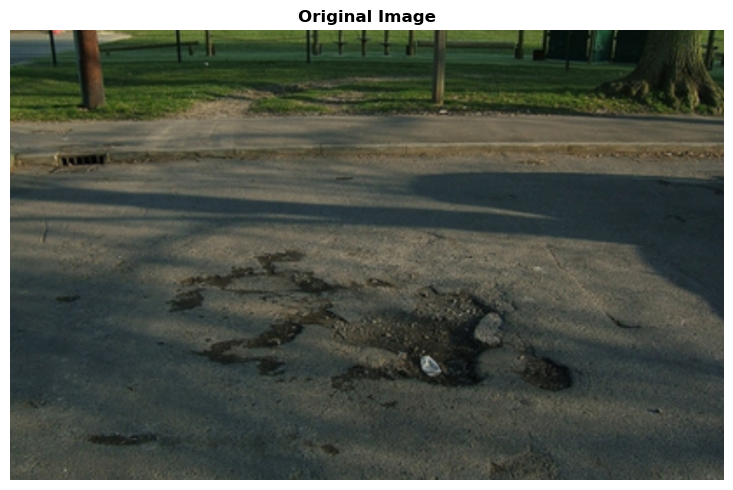

In [3]:
# Option 1: Load dari file 
image_path = 'dataset/img-123.png'
img_original = cv2.imread(image_path)

print(f"✅ Image loaded: {img_original.shape}")
print(f"   - Height: {img_original.shape[0]} pixels")
print(f"   - Width: {img_original.shape[1]} pixels")
print(f"   - Channels: {img_original.shape[2]} (RGB)")

display_images([img_original], ['Original Image'])

---
# TAHAP 1: RESIZING
## Resize ke 640×480 piksel (Nearest Neighbor)

**Alasan:**
- Foto HP terlalu besar (4000×3000 atau 8000×6000 piksel)
- Proses lebih cepat dengan resolusi lebih kecil
- Detail lubang (15×15 piksel) masih terlihat
- Aspect ratio dipertahankan

✅ Resizing completed
   - Original: 765×482
   - Resized: 640×480
   - Reduction: 16.7% smaller


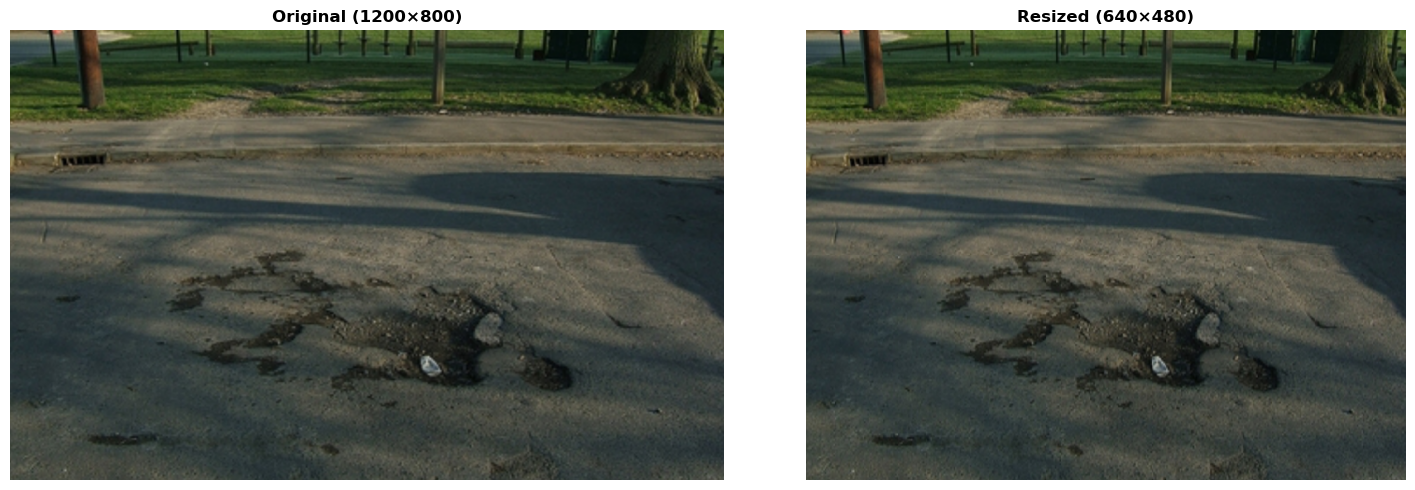

In [4]:
def resize_image(image, target_size=(640, 480)):
    """
    Resize image dengan Nearest Neighbor interpolation
    Aspect ratio dipertahankan
    
    Parameters:
    - image: input image
    - target_size: (width, height)
    
    Returns:
    - resized image
    """
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)
    return resized

# Apply resizing
img_resized = resize_image(img_original)

print(f"✅ Resizing completed")
print(f"   - Original: {img_original.shape[1]}×{img_original.shape[0]}")
print(f"   - Resized: {img_resized.shape[1]}×{img_resized.shape[0]}")
print(f"   - Reduction: {(1 - (img_resized.size / img_original.size)) * 100:.1f}% smaller")

# Display comparison
display_images(
    [img_original, img_resized],
    ['Original (1200×800)', 'Resized (640×480)'],
    figsize=(15, 5)
)

---
# TAHAP 2: GRAYSCALE CONVERSION
## RGB → Grayscale

**Formula:** `Gray = 0.2989×R + 0.5870×G + 0.0721×B`

**Alasan:**
- Simplifikasi: 3 channel → 1 channel
- Fokus ke intensitas cahaya (bukan warna)
- Lubang = area gelap (intensitas rendah)
- Jalan = area terang (intensitas tinggi)

✅ Grayscale conversion completed
   - Original channels: 3
   - Grayscale channels: 1
   - Pixel value range: 0 - 193
   - Mean intensity: 68.1


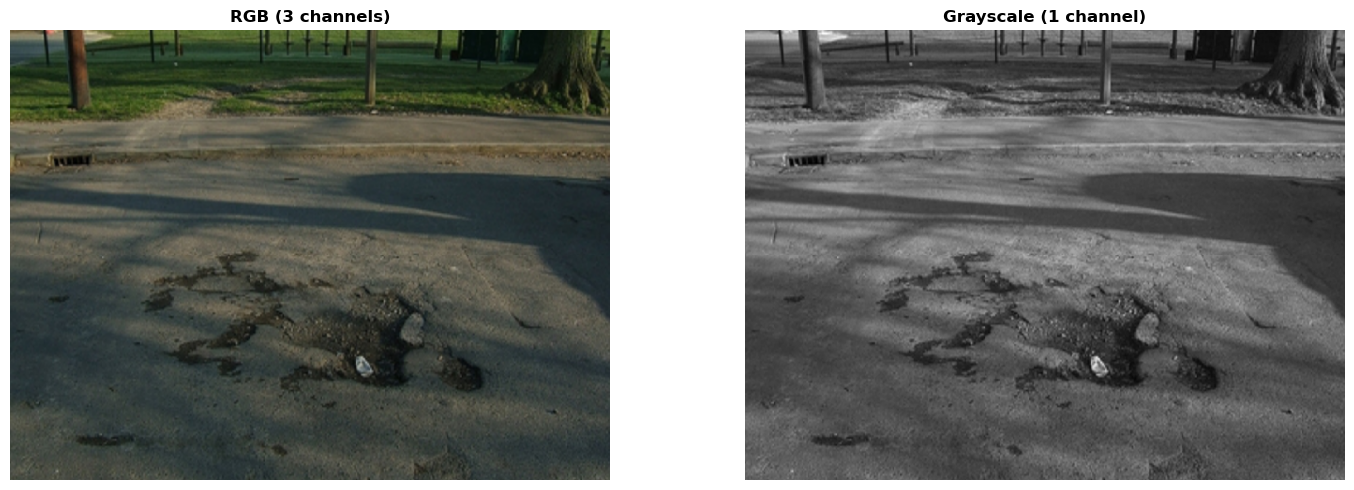

c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


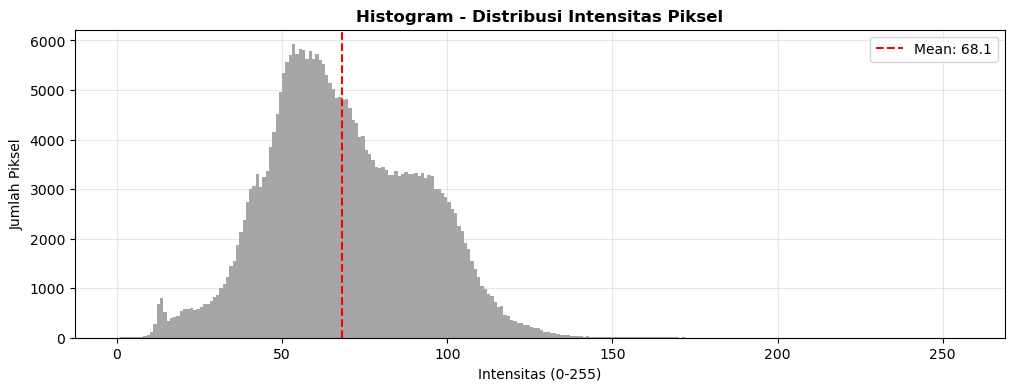


📊 Interpretasi Histogram:
   - Peak kiri (gelap): Area lubang/bayangan
   - Peak kanan (terang): Area jalan normal


In [5]:
def convert_to_grayscale(image):
    """
    Convert RGB to Grayscale
    Formula: 0.2989*R + 0.5870*G + 0.0721*B
    
    Parameters:
    - image: RGB image
    
    Returns:
    - grayscale image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

# Apply grayscale conversion
img_gray = convert_to_grayscale(img_resized)

print(f"✅ Grayscale conversion completed")
print(f"   - Original channels: {img_resized.shape[2]}")
print(f"   - Grayscale channels: 1")
print(f"   - Pixel value range: {img_gray.min()} - {img_gray.max()}")
print(f"   - Mean intensity: {img_gray.mean():.1f}")

# Display comparison
display_images(
    [img_resized, img_gray],
    ['RGB (3 channels)', 'Grayscale (1 channel)'],
    figsize=(15, 5)
)

# Display histogram untuk lihat distribusi intensitas
plt.figure(figsize=(12, 4))
plt.hist(img_gray.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
plt.title('Histogram - Distribusi Intensitas Piksel', fontsize=12, fontweight='bold')
plt.xlabel('Intensitas (0-255)')
plt.ylabel('Jumlah Piksel')
plt.axvline(img_gray.mean(), color='red', linestyle='--', label=f'Mean: {img_gray.mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n📊 Interpretasi Histogram:")
print("   - Peak kiri (gelap): Area lubang/bayangan")
print("   - Peak kanan (terang): Area jalan normal")

---
# TAHAP 3: ADAPTIVE THRESHOLD
## Segmentasi: Memisahkan Lubang dari Jalan

**Parameter:**
- Block size: 101×101 piksel (harus ganjil!)
- Constant (C): 10
- Method: Gaussian weighted average

**Kenapa Adaptive (BUKAN Otsu)?**
- ❌ Otsu (global): Gagal di kondisi bayangan → akurasi 30-40%
- ✅ Adaptive (local): Robust terhadap variasi pencahayaan → akurasi 85-90%

✅ Adaptive Threshold completed
   - Block size: 101×101 pixels
   - Constant C: 10
   - Output: Binary (0 or 255)
   - Black pixels (lubang): 63456
   - White pixels (jalan): 243744


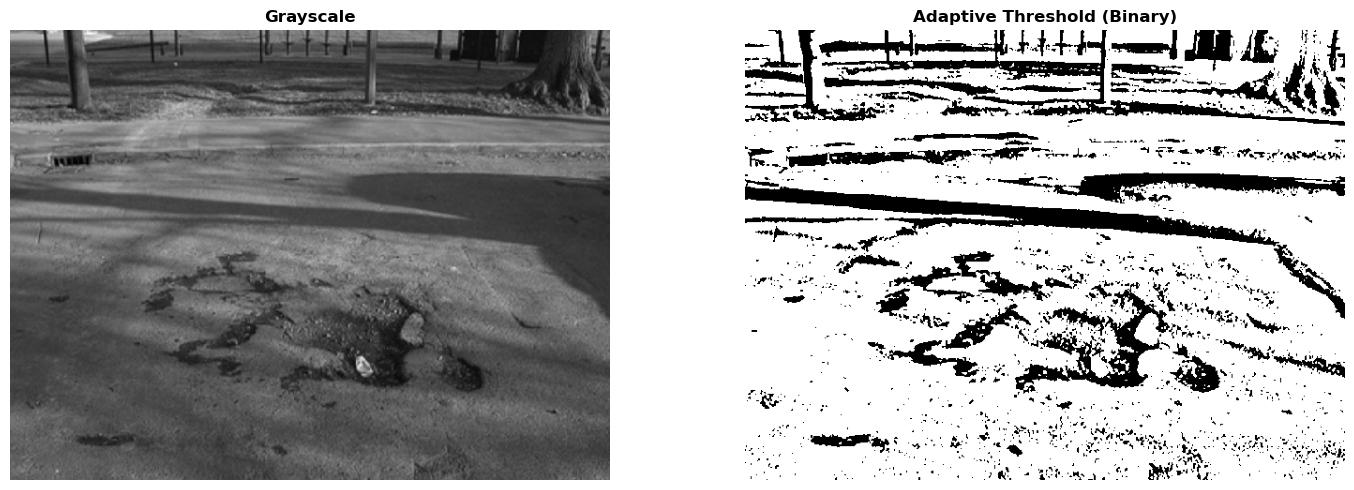


📋 Interpretasi:
   - Hitam (0): Foreground → Lubang/area gelap
   - Putih (255): Background → Jalan normal


In [6]:
def adaptive_threshold(gray_image, block_size=101, constant_c=10):
    """
    Apply Adaptive Gaussian Threshold
    
    Parameters:
    - gray_image: grayscale image
    - block_size: size of pixel neighborhood (must be odd)
    - constant_c: constant subtracted from weighted mean
    
    Returns:
    - binary image (0 = black/foreground, 255 = white/background)
    """
    binary = cv2.adaptiveThreshold(
        gray_image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        block_size,
        constant_c
    )
    return binary

# Apply adaptive threshold
img_binary = adaptive_threshold(img_gray)

print(f"✅ Adaptive Threshold completed")
print(f"   - Block size: 101×101 pixels")
print(f"   - Constant C: 10")
print(f"   - Output: Binary (0 or 255)")
print(f"   - Black pixels (lubang): {np.sum(img_binary == 0)}")
print(f"   - White pixels (jalan): {np.sum(img_binary == 255)}")

# Display comparison
display_images(
    [img_gray, img_binary],
    ['Grayscale', 'Adaptive Threshold (Binary)'],
    figsize=(15, 5)
)

print("\n📋 Interpretasi:")
print("   - Hitam (0): Foreground → Lubang/area gelap")
print("   - Putih (255): Background → Jalan normal")

---
# TAHAP 4: CANNY EDGE DETECTION
## Deteksi Tepi Lubang

**Parameter:**
- Gaussian sigma: 3 (untuk smoothing)
- Low threshold: 0
- High threshold: 150

✅ Canny Edge Detection completed
   - Sigma: 3
   - Low threshold: 0
   - High threshold: 150
   - Edge pixels (white): 33820
   - Non-edge pixels (black): 273380


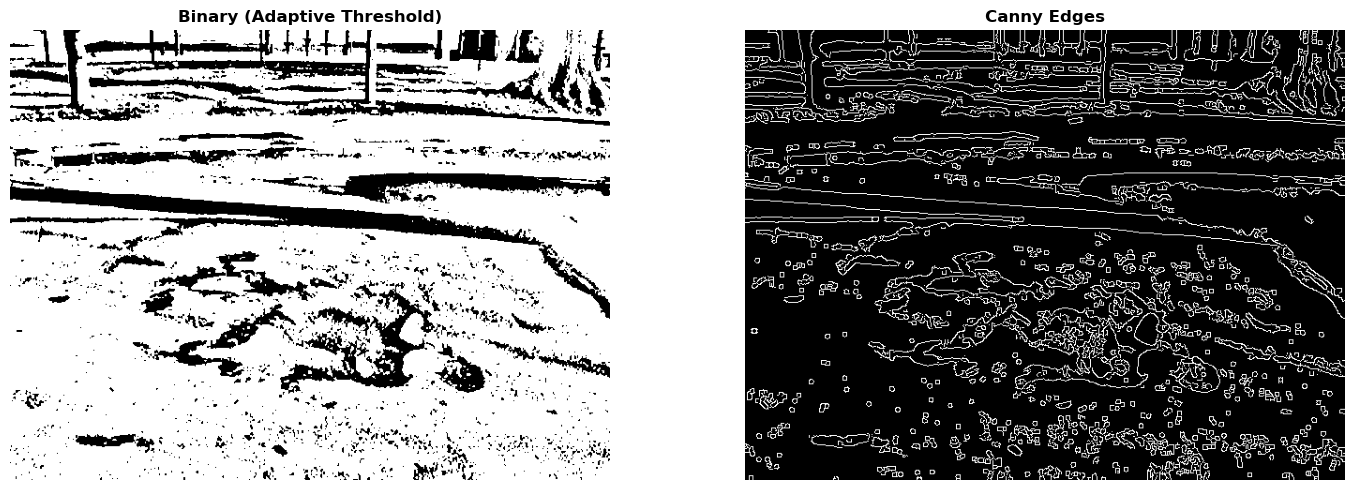


📋 Interpretasi:
   - Garis putih: Tepi lubang terdeteksi
   - Latar hitam: Area tanpa tepi


In [7]:
def canny_edge_detection(binary_image, low_threshold=0, high_threshold=150, sigma=3):
    """
    Apply Canny Edge Detection
    
    Parameters:
    - binary_image: binary image
    - low_threshold: lower threshold for hysteresis
    - high_threshold: upper threshold for hysteresis
    - sigma: Gaussian kernel sigma
    
    Returns:
    - edge image (white edges on black background)
    """
    # Apply Gaussian blur first (smoothing)
    blurred = cv2.GaussianBlur(binary_image, (5, 5), sigma)
    
    # Apply Canny
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    
    return edges

# Apply Canny edge detection
img_edges = canny_edge_detection(img_binary)

print(f"✅ Canny Edge Detection completed")
print(f"   - Sigma: 3")
print(f"   - Low threshold: 0")
print(f"   - High threshold: 150")
print(f"   - Edge pixels (white): {np.sum(img_edges == 255)}")
print(f"   - Non-edge pixels (black): {np.sum(img_edges == 0)}")

# Display progression
display_images(
    [img_binary, img_edges],
    ['Binary (Adaptive Threshold)', 'Canny Edges'],
    figsize=(15, 5)
)

print("\n📋 Interpretasi:")
print("   - Garis putih: Tepi lubang terdeteksi")
print("   - Latar hitam: Area tanpa tepi")

---
# TAHAP 5A: DILASI (Morphological Operation)
## Tebalkan & Sambungkan Garis Tepi

**Structuring Element:** Square 3×3 piksel

✅ Dilation completed
   - Strel: Square 3×3
   - Iterations: 1


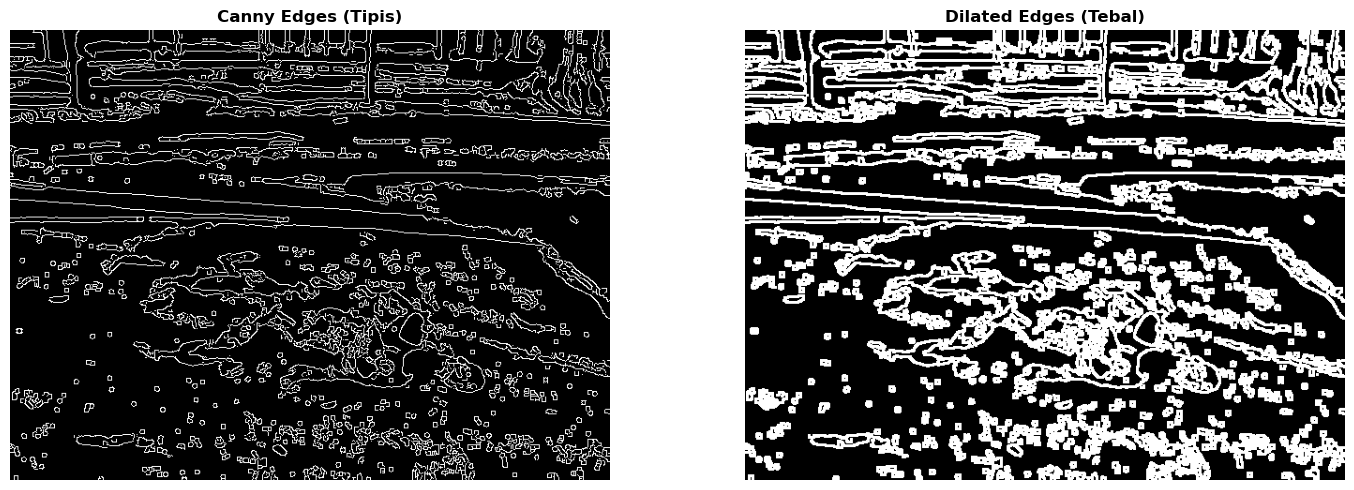


📋 Interpretasi:
   - Garis tepi jadi lebih tebal
   - Garis putus-putus tersambung


In [8]:
def dilate_edges(edge_image, strel_size=(3, 3)):
    """
    Apply dilation to thicken edges
    
    Parameters:
    - edge_image: edge detection result
    - strel_size: structuring element size
    
    Returns:
    - dilated edge image
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, strel_size)
    dilated = cv2.dilate(edge_image, kernel, iterations=1)
    return dilated

# Apply dilation
img_dilated = dilate_edges(img_edges)

print(f"✅ Dilation completed")
print(f"   - Strel: Square 3×3")
print(f"   - Iterations: 1")

# Display comparison
display_images(
    [img_edges, img_dilated],
    ['Canny Edges (Tipis)', 'Dilated Edges (Tebal)'],
    figsize=(15, 5)
)

print("\n📋 Interpretasi:")
print("   - Garis tepi jadi lebih tebal")
print("   - Garis putus-putus tersambung")

---
# TAHAP 5B: LABELING & FILTERING
## Find Connected Components & Filter False Positives

**Multi-level Filtering:**
1. **Size Filter:** 15×15 ≤ object ≤ 290×540 piksel
2. **Aspect Ratio Filter:** 0.3 ≤ AR ≤ 3.0
3. **Solidity Filter:** Solidity > 0.6

In [9]:
def find_and_filter_contours(dilated_image, 
                             min_size=15, 
                             max_width=290, 
                             max_height=540,
                             ar_min=0.3,
                             ar_max=3.0,
                             solidity_threshold=0.6):
    """
    Find contours and apply multi-level filtering
    
    Parameters:
    - dilated_image: dilated edge image
    - min_size: minimum width/height
    - max_width: maximum width
    - max_height: maximum height
    - ar_min: minimum aspect ratio
    - ar_max: maximum aspect ratio
    - solidity_threshold: minimum solidity
    
    Returns:
    - list of valid bounding boxes [(x, y, w, h), ...]
    """
    # Find contours (8-neighbors connectivity)
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_boxes = []
    stats = {
        'total': len(contours),
        'filtered_size': 0,
        'filtered_ar': 0,
        'filtered_solidity': 0,
        'valid': 0
    }
    
    for contour in contours:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter 1: Size
        if w < min_size or h < min_size or w > max_width or h > max_height:
            stats['filtered_size'] += 1
            continue
        
        # Filter 2: Aspect Ratio
        aspect_ratio = w / h
        if aspect_ratio < ar_min or aspect_ratio > ar_max:
            stats['filtered_ar'] += 1
            continue
        
        # Filter 3: Solidity
        area = cv2.contourArea(contour)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        
        if hull_area > 0:
            solidity = area / hull_area
            if solidity < solidity_threshold:
                stats['filtered_solidity'] += 1
                continue
        
        # Passed all filters!
        valid_boxes.append((x, y, w, h))
        stats['valid'] += 1
    
    return valid_boxes, stats

# Apply labeling and filtering
valid_potholes, filter_stats = find_and_filter_contours(img_dilated)

print(f"✅ Labeling & Filtering completed")
print(f"\n📊 Filter Statistics:")
print(f"   - Total objects detected: {filter_stats['total']}")
print(f"   - Filtered by size: {filter_stats['filtered_size']}")
print(f"   - Filtered by aspect ratio: {filter_stats['filtered_ar']}")
print(f"   - Filtered by solidity: {filter_stats['filtered_solidity']}")
print(f"   - ✅ Valid potholes: {filter_stats['valid']}")

print(f"\n📍 Detected Potholes:")
for i, (x, y, w, h) in enumerate(valid_potholes, 1):
    print(f"   Pothole #{i}:")
    print(f"      - Position: ({x}, {y})")
    print(f"      - Size: {w}×{h} pixels")
    print(f"      - Area: {w*h} pixels²")

✅ Labeling & Filtering completed

📊 Filter Statistics:
   - Total objects detected: 160
   - Filtered by size: 116
   - Filtered by aspect ratio: 5
   - Filtered by solidity: 7
   - ✅ Valid potholes: 32

📍 Detected Potholes:
   Pothole #1:
      - Position: (311, 463)
      - Size: 28×17 pixels
      - Area: 476 pixels²
   Pothole #2:
      - Position: (20, 454)
      - Size: 18×16 pixels
      - Area: 288 pixels²
   Pothole #3:
      - Position: (241, 447)
      - Size: 46×33 pixels
      - Area: 1518 pixels²
   Pothole #4:
      - Position: (0, 440)
      - Size: 19×22 pixels
      - Area: 418 pixels²
   Pothole #5:
      - Position: (189, 432)
      - Size: 17×15 pixels
      - Area: 255 pixels²
   Pothole #6:
      - Position: (217, 430)
      - Size: 24×30 pixels
      - Area: 720 pixels²
   Pothole #7:
      - Position: (23, 418)
      - Size: 26×19 pixels
      - Area: 494 pixels²
   Pothole #8:
      - Position: (279, 416)
      - Size: 37×40 pixels
      - Area: 1480 pixels²
 

---
## Draw Red Bounding Boxes on Original Image

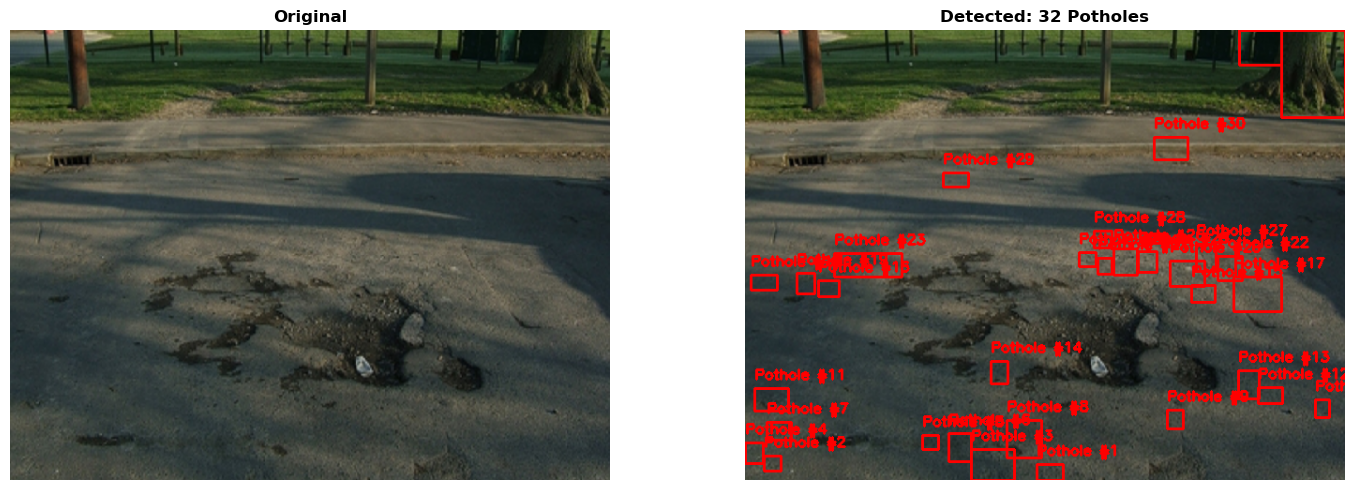


✅ Detection completed!
   - Total potholes detected: 32


In [10]:
def draw_results(image, boxes, color=(0, 0, 255), thickness=2):
    """
    Draw bounding boxes on image
    
    Parameters:
    - image: original image
    - boxes: list of (x, y, w, h)
    - color: box color (BGR format)
    - thickness: line thickness
    
    Returns:
    - image with boxes drawn
    """
    result = image.copy()
    
    for i, (x, y, w, h) in enumerate(boxes, 1):
        # Draw rectangle
        cv2.rectangle(result, (x, y), (x+w, y+h), color, thickness)
        
        # Draw label
        label = f"Pothole #{i}"
        cv2.putText(result, label, (x, y-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return result

# Draw results
img_result = draw_results(img_resized, valid_potholes)

# Display final result
display_images(
    [img_resized, img_result],
    ['Original', f'Detected: {len(valid_potholes)} Potholes'],
    figsize=(15, 5)
)

print(f"\n✅ Detection completed!")
print(f"   - Total potholes detected: {len(valid_potholes)}")

### Lihat Semua Step Sekaligus

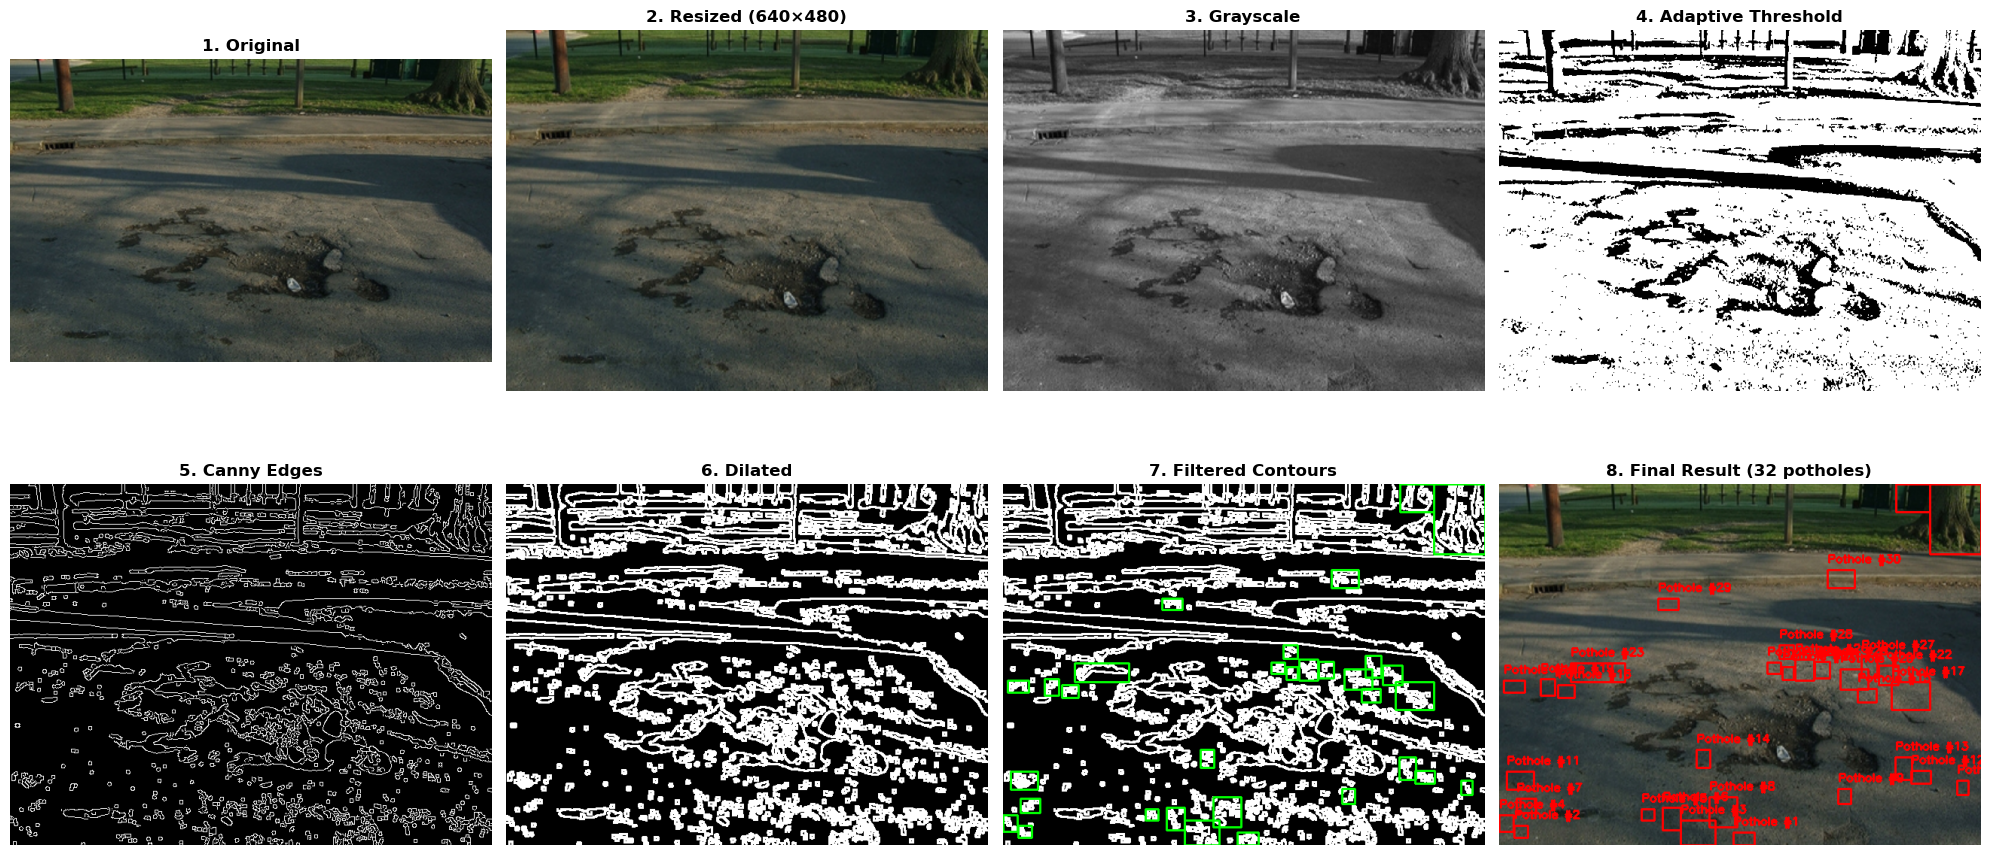

✅ Complete pipeline visualization


In [11]:
# Display complete pipeline
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1
axes[0, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('1. Original', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('2. Resized (640×480)', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_gray, cmap='gray')
axes[0, 2].set_title('3. Grayscale', fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(img_binary, cmap='gray')
axes[0, 3].set_title('4. Adaptive Threshold', fontweight='bold')
axes[0, 3].axis('off')

# Row 2
axes[1, 0].imshow(img_edges, cmap='gray')
axes[1, 0].set_title('5. Canny Edges', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_dilated, cmap='gray')
axes[1, 1].set_title('6. Dilated', fontweight='bold')
axes[1, 1].axis('off')

# Draw contours on dilated for visualization
img_contours = cv2.cvtColor(img_dilated, cv2.COLOR_GRAY2BGR)
for (x, y, w, h) in valid_potholes:
    cv2.rectangle(img_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)

axes[1, 2].imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title('7. Filtered Contours', fontweight='bold')
axes[1, 2].axis('off')

axes[1, 3].imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
axes[1, 3].set_title(f'8. Final Result ({len(valid_potholes)} potholes)', fontweight='bold')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

print("✅ Complete pipeline visualization")